## 1: Event detection

Before building a machine learning-based earthquake detector, let's try out two traditional methods for comparison: STA/LTA ratio, and crosscorrelation.

First: Import the libraries that we need.

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import zscore

## Get the data file

For this exercise we'll use a small set of sample events from the [STEAD](https://github.com/smousavi05/STEAD) dataset, which contains 60 s long waveforms at 100 Hz, for three components. In the sample file here, only the vertical component is present.

The original dataset files come in a somewhat inconvenient format, so for this file (and the ones in the following exercises) they have been reformatted -- just so you know, in cases you later want to download all of it.

In [3]:
# ! wget https://github.com/smaeland/norsar-ml-workshop/raw/refs/heads/main/sample_events_Zonly_TRAIN.h5

## Open the file and check the contents

For performance reasons the file is in a binary format, which can't look at directly. But we can list the contents like so:

In [4]:
filename = 'sample_events_Zonly_TRAIN.h5'
fin = h5py.File(filename, 'r')
print('Datasets in file:')
print(fin.keys())

Datasets in file:
<KeysViewHDF5 ['mag', 'p_start', 's_start', 'type', 'waveforms']>


Now we can access each dataset and assign it to a variable.

In [5]:
waveforms = fin.get('waveforms')[:]
event_types = fin.get('type')[:]
p_start = fin.get('p_start')[:]
s_start = fin.get('s_start')[:]
magnitude = fin.get('mag')[:]

print(f'Waveforms data shape: {waveforms.shape}')
print(f'-> {waveforms.shape[0]} events, {waveforms.shape[1]} data points per channel, {waveforms.shape[2]} channels')

Waveforms data shape: (10, 6000, 1)
-> 10 events, 6000 data points per channel, 1 channels


Before we move on, we normalise the waveforms to unit amplitude.

In [76]:
max_vals = np.max(np.abs(waveforms), axis=1, keepdims=True)
waveforms /= (max_vals + 1e-8)

## Plot an event

Let's plot the first event in the file. The file also contains the start positions for the P and S wave, if present. We'll add this as vertical lines on the plot.

The code below is not super obvious unless you have experience with the Matplotlib library -- but that's not very important for the workshop. In case you want to change it, ChatGPT and friends are experts at these things.

First some general settings:

In [15]:
# Which event to look at (starts at 0)
event_index = 1

if event_index > len(waveforms):
    raise RuntimeError(f'Event index {event_index} greater than number of events {len(waveforms)}')

# Sampling rate
sampling_rate = 100.0

# Channel index (we have only one, so it's 0)
channel_index = 0

Now for the plotting:

Earthquake, mag 3.6


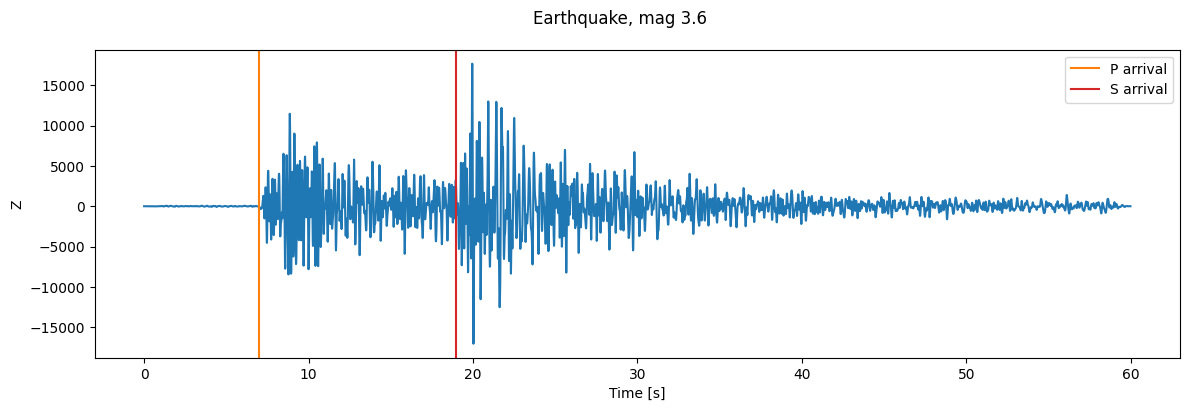

In [16]:
# Get info for this event
waveform = waveforms[event_index, :, channel_index]
p_pick = p_start[event_index]
s_pick = s_start[event_index]
mag = magnitude[event_index]
event_type = event_types[event_index]

# Create the figure 
fig = plt.figure(figsize=(14, 4))

# Create points along the x axis 
time_points = np.arange(len(waveform)) / sampling_rate

# Plot
plt.plot(time_points, waveform)

if p_pick is not None:
    p_arrival = plt.axvline(p_pick / sampling_rate, color='tab:orange', label='P arrival')
if s_pick is not None:
    s_arrival = plt.axvline(s_pick / sampling_rate, color='tab:red', label='S arrival')

plt.ylabel('Z')
    
if p_pick is not None:
    plt.legend(handles=[p_arrival, s_arrival], loc='upper right')

title = f'Earthquake, mag {mag:.1f}' if event_type == 1 else 'Noise'
plt.suptitle(title)

plt.xlabel('Time [s]')

print(title)

## First event detection method: STA/LTA

We want to detect the event shown above, using the ratio of short-term average amplitude (STA) and long-term average (LTA). We can relatively easily compute this ourselves, but the useful [ObsPy](https://docs.obspy.org/index.html) library also provides it for us. The function is called `classis_sta_lta` and can be imported from the `signal.trigger` module. 

Text(0.5, 0, 'Time [s]')

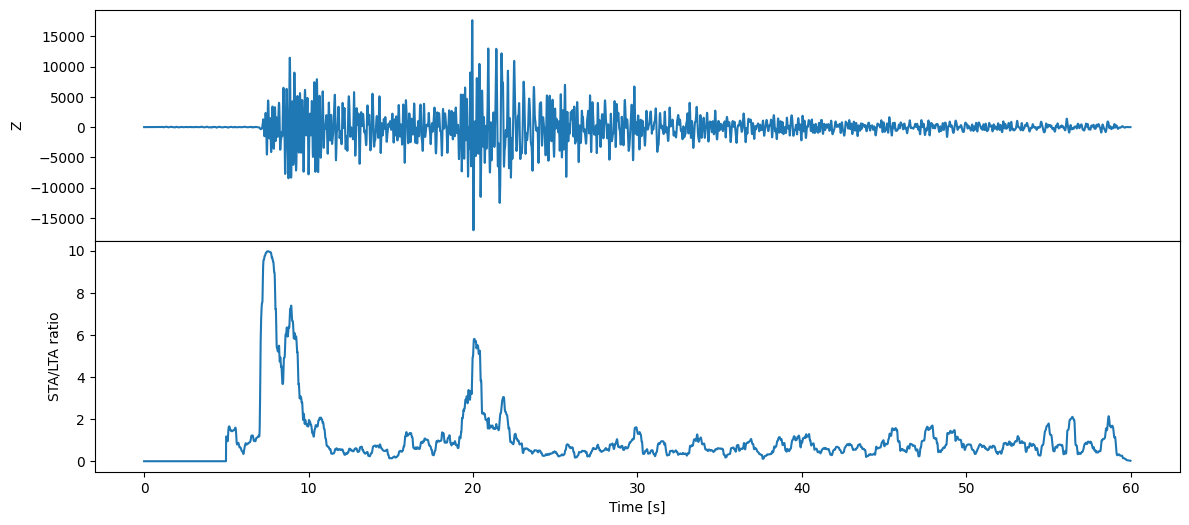

In [18]:
from obspy.signal.trigger import classic_sta_lta

# Create the plot, with two panels this time
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(14, 6))
fig.subplots_adjust(hspace=0)

time_points = np.arange(len(waveform)) / sampling_rate

# Compute the ratio
sta_lta = classic_sta_lta(waveform, int(0.5*sampling_rate), int(5.0*sampling_rate))

# Plot data with STA/LTA ratio below
axes[0].plot(time_points, waveform)
axes[1].plot(time_points, sta_lta)

axes[0].set_ylabel('Z')
axes[1].set_ylabel('STA/LTA ratio')
axes[1].set_xlabel('Time [s]')


Looks good! If we now put a threshold on the STA/LTA ratio, we have an event detector.

### Optional exercise 1:

Implement such a threshold, and add a line to the plot showing detections. Something like `np.where(sta_lta > threshold)` can prove useful.

### Optional exercise 2:

Replace the `classic_sta_lta` function with other methods shown in the ObsPy [trigger tutorial](https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html), for instance `recursive_sta_lta` or `z_detect`. 

## Second method: Template cross-correlation

For the next test, let's use the first event we plotted as a template, and cross-correlate it with other potential events.

Again, ObsPy has a conventient function for us to use: `correlate_template`. We can write a new function around it that allows for some quick experimentation.

In [49]:
from obspy.signal.cross_correlation import correlate_template

def plot_correlation(event_index, template_index):

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(14, 6))
    fig.subplots_adjust(hspace=0)

    # Get the event and template waveforms
    waveform = waveforms[event_index, :, channel_index]
    template = waveforms[template_index, :, channel_index]

    time_points = np.arange(len(waveform)) / sampling_rate

    # Check that the template contains picks (i.e. is not noise)
    # If you like, you can add random numbers here instead, to be able to use noise events too.
    template_p_start = p_start[template_index]
    template_s_start = s_start[template_index]

    if template_p_start < 0 or template_s_start < 0:
        raise RuntimeError('Template waveform is a noise event') 
    
    # We'll cut it down to start 1 s before the P arrival, and stop 10 s after the S arrival.
    template_start_sample = int(template_p_start - 1*sampling_rate)
    template_end_sample = int(template_s_start + 10*sampling_rate)
    template = template[template_start_sample : template_end_sample]
    
    # Compute the cross-correlation, and find the position of max correlation
    corr = correlate_template(waveform, template, mode='same')
    max_corr_index = np.argmax(corr) - len(template)//2
    max_corr_time_points = (np.arange(len(template)) + max_corr_index) / sampling_rate
    
    print('waveform.shape:', waveform.shape)
    print('template.shape:', template.shape)
    print('corr.shape:', corr.shape)
    
    axes[0].plot(time_points, waveform)
    axes[1].plot(time_points, corr)
    axes[2].plot(time_points, waveform / np.max(waveform), alpha=0.7)
    axes[2].plot(max_corr_time_points, template / np.max(template), color='tab:orange', label='Template')

    axes[0].set_ylabel('Z')
    axes[1].set_ylabel('Correlation')
    axes[1].set_ylim(-1.05, 1.05)
    axes[2].set_ylabel('Best match')
    axes[2].legend(loc='upper right')
        
    axes[1].set_xlabel('Time [s]')    

Let's try it out.

First, correlating a waveform against itself (it should hopefully be able to detect itself):

waveform.shape: (6000,)
template.shape: (2294,)
corr.shape: (6000,)


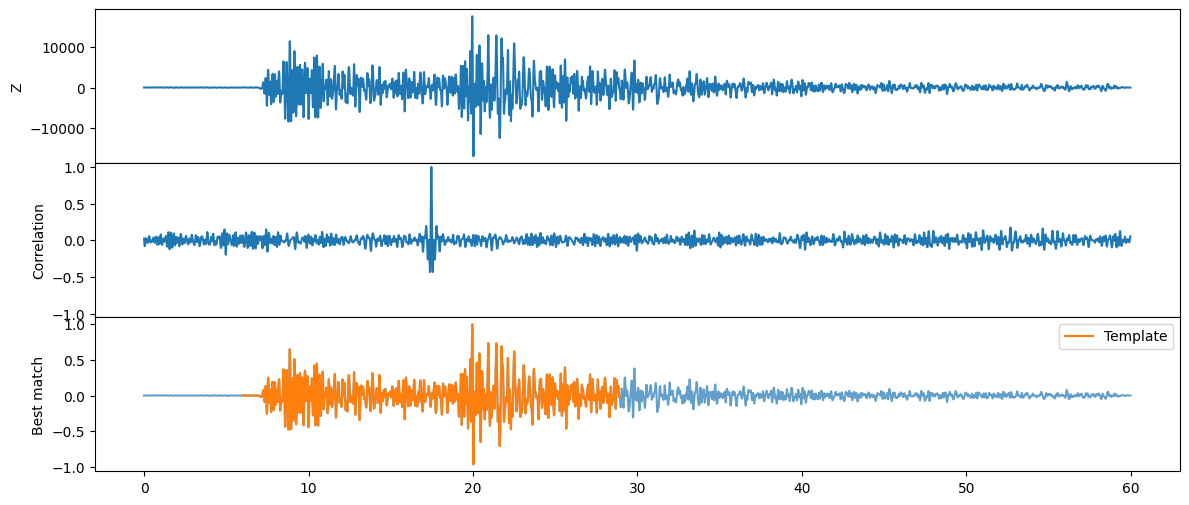

In [50]:
plot_correlation(event_index=1, template_index=1)

Now we can try it agaist noise:

waveform.shape: (6000,)
template.shape: (2294,)
corr.shape: (6000,)


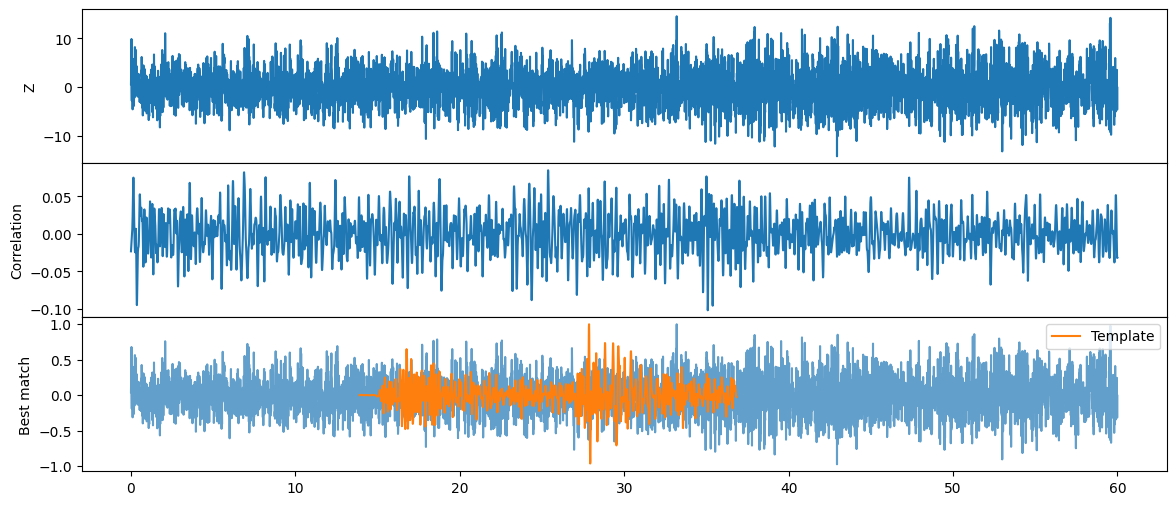

In [43]:
plot_correlation(event_index=0, template_index=1)

Or agaist a different event:

waveform.shape: (6000,)
template.shape: (2294,)
corr.shape: (6000,)


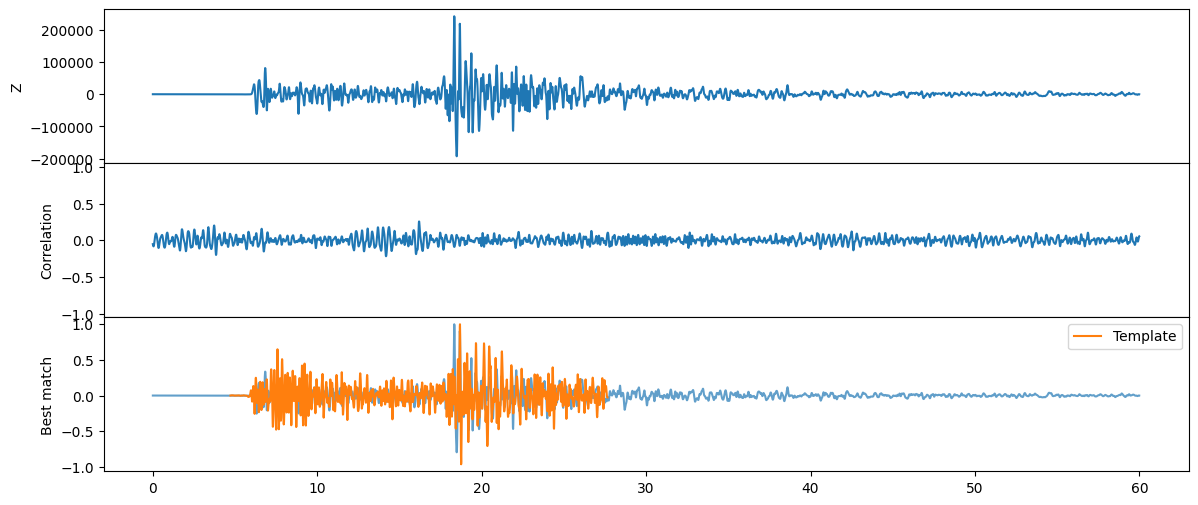

In [51]:
plot_correlation(event_index=2, template_index=1)

### Exercise: 

Edit the event and template indices to evaluate our detection capabilities on different events.

## Third event detection method: Machine learning-based model

Last piece of our comparison is of course to add a ML-based model. For now we'll just use it, but in the following exercises we'll also train our own an try to improve on it. 

First, get the model file:

In [ ]:
! wget https://github.com/smaeland/norsar-ml-workshop/raw/refs/heads/dev/phase_picker.keras

Then, import the required library, and load the model.

In [52]:
import tensorflow as tf

model = tf.keras.models.load_model('phase_picker.keras')

I0000 00:00:1757949342.311056   31523 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18449 MB memory:  -> device: 0, name: NVIDIA RTX A4500, pci bus id: 0000:41:00.0, compute capability: 8.6


In [65]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 6000, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 3000, 32)  │        128 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 32)  │        128 │ conv1d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 3000, 32)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 3000, 32)  │          0 │ activation_15[0]… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 3000, 64)  │      6,208 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 64)  │        256 │ conv1d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 3000, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 3000, 64)  │     12,352 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3000, 64)  │        256 │ conv1d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 1500, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 1500, 64)  │      2,112 │ activation_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 1500, 64)  │          0 │ max_pooling1d_7[… │
│                     │                   │            │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 1500, 64)  │          0 │ add_7[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 1500, 64)  │     12,352 │ activation_18[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1500, 64)  │        256 │ conv1d_41[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 1500, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 1500, 64)  │     12,352 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1500, 64)  │        256 │ conv1d_42[0][0] 

 Total params: 537,227 (2.05 MB)

 Trainable params: 178,499 (697.26 KB)

 Non-trainable params: 1,728 (6.75 KB)

 Optimizer params: 357,000 (1.36 MB)

Now we're ready to run it:

In [79]:
def ml_detect(event_index):

    waveform = waveforms[event_index, :, :]
    waveform = np.expand_dims(waveform, axis=0)
    #waveform = np.expand_dims(waveform, axis=2)

    print('waveform.shape:', waveform.shape)
    
    predictions = model(waveform)

    print('predictions.shape:', predictions.shape)
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(14, 6))
    fig.subplots_adjust(hspace=0)

    time_points = np.arange(waveform.shape[1]) / sampling_rate

    axes[0].plot(time_points, waveform[0, :, 0])
    axes[1].plot(time_points, predictions[0, :, 0], label='P similarity')
    axes[1].plot(time_points, predictions[0, :, 1], label='S similarity')
    axes[1].legend(loc='upper right')
        
    axes[0].set_ylabel('Z')
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel('ML prediction')
    axes[1].set_xlabel('Time [s]')

waveform.shape: (1, 6000, 1)
predictions.shape: (1, 6000, 3)


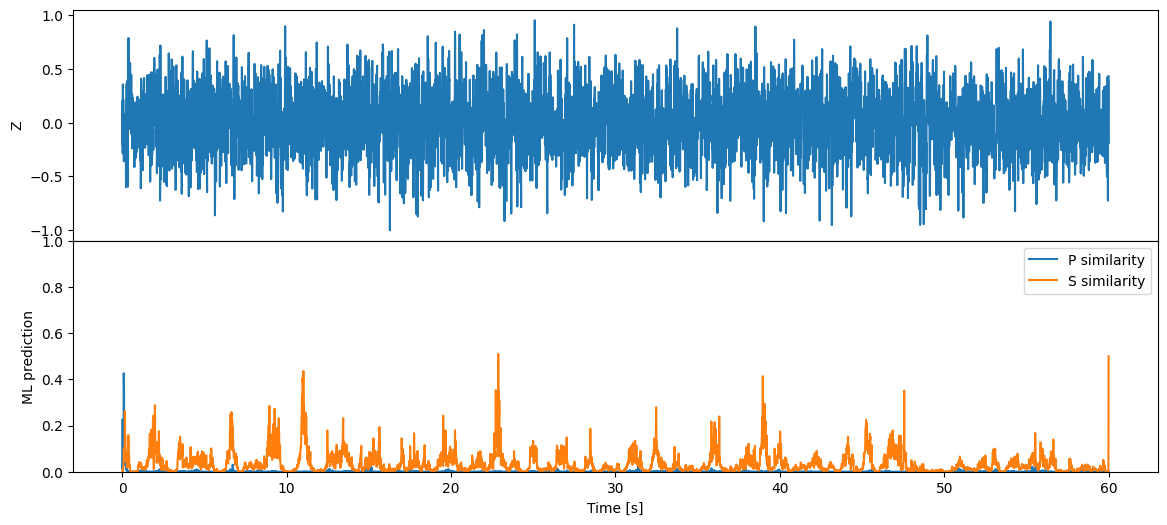

In [84]:
ml_detect(event_index=4)

### Exercise

Our model is a small one, based on a miniaturised version of the [PhaseNet](https://academic.oup.com/gji/article/216/1/261/5129142) model. Its main purpose in this case is to run fast even without a GPU, and it's likely prone to making errors. Try different event numbers to see where it works and where it makes mistakes. 

This model is the one to beat when we start training our own in the next exer